## Create a network which can take in a MNIST Data image and a Random number and output the digit from image and sum of this digit and random number entered

![problem modal](./assign.png "Problem Statement Exmple Modal")

1. the "number" that was represented by the MNIST image, and
2. the "sum" of this number with the random number that was generated and sent as the input to the network
3. you can mix fully connected layers and convolution layers
4. you can use one-hot encoding to represent the random number input as well as the "summed" output.

### Import All Libs

In [22]:
from __future__ import print_function

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [23]:
torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Design Multi Input Multi Output Network

1. This net should take in two inputs, 
    a. Mnist image (1, 28, 28)
    b. Random vector as one hot encoded (1, 10)
2. Output two vectors
    a. Predicted logits for MNIST digit (1, 10)
    b. Predicted logist for sum of both numbers (1, 19)
    
#### Methodology
1. Input image is first passed on to a convolution layer
2. Input number as a one hot encoder is passed on to fc layer with output sixe equal to outputsize of first convlayer
3. Now the output from above two layers is concatinated in a way that this fc layer output becomes one of the channel
4. Further convolution is performed
5. In the output just bfore the last layer the output from previous layer is flattered and fed to linear layer with respective output.

In [24]:
class MIMO(nn.Module):
    def __init__(self):
        super(MIMO, self).__init__()
        # Input 1
        self.conv1 = nn.Conv2d(1, 7, 3)
        # Input 2
        self.fc1 = nn.Linear(10, 1*26*26)
        
        # Model
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 64, 3)
        
        # Output Layer
        self.fc2 = nn.Linear(64*3*3, 10)
        self.fc3 = nn.Linear(64*3*3, 19)
        
        
    def forward(self, im, ra):
        x1 = self.conv1(im)
        x2 = self.fc1(ra)
        
        # Concatinate
        x = torch.cat((x1, x2.view(-1, 1, 26, 26)), dim=1)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)

        x = x.view(-1, 64*3*3)
        
        o1 = self.fc2(x)
        o2 = self.fc3(x)
        
        return F.log_softmax(o1, dim = 1), F.log_softmax(o2, dim = 1)

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1            [-1, 7, 26, 26]              70
            Linear-2               [-1, 1, 676]           7,436
            Conv2d-3           [-1, 16, 24, 24]           1,168
         MaxPool2d-4           [-1, 16, 12, 12]               0
       BatchNorm2d-5           [-1, 16, 12, 12]              32
            Conv2d-6           [-1, 32, 10, 10]           4,640
         MaxPool2d-7             [-1, 32, 5, 5]               0
       BatchNorm2d-8             [-1, 32, 5, 5]              64
            Conv2d-9             [-1, 64, 3, 3]          18,496
           Linear-10                   [-1, 10]           5,770
           Linear-11                   [-1, 19]          10,963
```

### Dataset Creation
Here we have created a custom dataset, whch spits four values image, im_label, random_number, sum \[(1, 28, 28), (1, 1), (1, 19), (1, 1) \]

1. Download Raw dataset from MNIST website
2. Define a cutom dataset function
3. Load dataset as pandas dataframe
4. Create a data list from dataframe with these pixels and reshape them to (28, 28, 1)
5. Add function __getitem__ , this function will first load image from list, generate a new random number, create onehot vctor for that and then return them

In [25]:
class MnistAndRandomNumberDataset(Dataset):
    def __init__(self, transforms=None):
        self.img_dim = (28, 28)
        self.transforms = transforms
        self.idata = []
        self.ilabel = []
        
        # Read Dataset
        df = pd.read_csv("archive/mnist_784.csv")
        
        # Get Labels
        self.ilabel = list(df["class"])
        
        # Drop Labels from DataFrame
        df.drop("class", 1, inplace=True)
        
        # Convert data to np array
        self.idata = np.array(df.values.tolist()).reshape(70000, self.img_dim[0], self.img_dim[1], 1)

    def __len__(self):
        return len(self.idata)

    def __getitem__(self, idx):
        # Read Image and Label
        im = self.idata[idx]
        label = self.ilabel[idx]
        # Convert label to tensor
        label = torch.tensor(label)
        
        # Apply Transforms
        if self.transforms is not None:
            im = self.transforms(im)
        im = im.to(torch.float)
        
        # Create random input
        rval = torch.randint(0, 9, (1,))[0]

        # Convert class id to tensor
        rlabel = label + rval
        
        # Convert value to one hot
        rval = F.one_hot(rval, num_classes=10).to(torch.float)

        return (im, label, rval, rlabel)

### Load Dataset
1. Split dataset into train and test (80/20)
2. Create Loaded with respective splits and enable shuffle

In [26]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

batch_size = 64

# Define transform for conbverting image to tensor before it can be fed to network
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = MnistAndRandomNumberDataset(transforms=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

## Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, **kwargs)

#### Visualize Dataset
Print some random samples to see how images from our dataset looks like

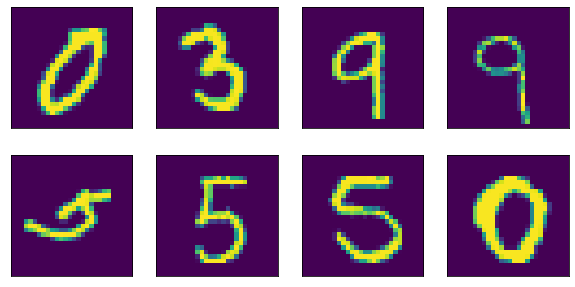

In [27]:
# Print Random Samples
for imgs, labels, rvs, rlabels in train_loader:
    fig = plt.figure(figsize = (10, 5))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(imgs[i].numpy().transpose(1, 2, 0))
    break

### Training
1. Define train loop
2. Define test loop

#### Loss Calculation 
In out backpropogation we are using **negative log likelihood loss**. `nll_loss`, _`F.nll_loss`_  for a multi-class classification use case the model output is expected to contain log probabilities (applied F.log_softmax as the last activation function on the output) and have the shape \[batch_size, nb_classes\]. The target should be a LongTensor in the shape \[batch_size\] and should contain the class indices in the range \[0, nb_classes-1\].
For More Details Refer [Here](https://medium.com/@bhardwajprakarsh/negative-log-likelihood-loss-why-do-we-use-it-for-binary-classification-7625f9e3c944)

In [36]:
def train(model, train_loader, optimizer, scheduler, epoch, device):
    model.train()
    iepoch_loss = 0
    icorrect = 0
    repoch_loss = 0
    rcorrect = 0
    for idata, itarget, rdata, rtarget in train_loader:
        idata, itarget, rdata, rtarget = idata.to(device), itarget.to(device), rdata.to(device), rtarget.to(device)
        optimizer.zero_grad()
        ioutput, routput = model(idata, rdata)
        
        iloss = F.nll_loss(ioutput, itarget)
        rloss = F.nll_loss(routput, rtarget)
        loss = iloss + rloss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        ipred = ioutput.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        icorrect += ipred.eq(itarget.view_as(ipred)).sum().item()
        iepoch_loss += iloss.item()
        
        rpred = routput.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        rcorrect += rpred.eq(rtarget.view_as(rpred)).sum().item()
        repoch_loss += rloss.item()
      
    return iepoch_loss / len(train_loader), icorrect, repoch_loss / len(train_loader), rcorrect

def test(model, test_loader, device):
    model.eval()
    itest_loss = 0
    icorrect = 0
    rtest_loss = 0
    rcorrect = 0
    with torch.no_grad():
        for idata, itarget, rdata, rtarget in test_loader:
            idata, itarget, rdata, rtarget = idata.to(device), itarget.to(device), rdata.to(device), rtarget.to(device)
            ioutput, routput = model(idata, rdata)
            
            itest_loss += F.nll_loss(ioutput, itarget, reduction='sum').item()  # sum up batch loss
            ipred = ioutput.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            icorrect += ipred.eq(itarget.view_as(ipred)).sum().item()
            
            rtest_loss += F.nll_loss(routput, rtarget, reduction='sum').item()  # sum up batch loss
            rpred = routput.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            rcorrect += rpred.eq(rtarget.view_as(rpred)).sum().item()

    itest_loss /= len(test_loader.dataset)
    rtest_loss /= len(test_loader.dataset)
    
    return itest_loss, icorrect, rtest_loss, rcorrect

In [37]:
import time
import math

model = MIMO().to(device)

# Train Params
epochs = 10
lr = 0.0005
max_lr = 0.001
steps_per_epoch=len(train_loader)

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("\n")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs, anneal_strategy='linear')

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

for epoch in range(epochs):
    print(f'Epoch: {epoch+1:02}')
    print(f'\t   Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    start_time = time.time()

    itrain_loss, itrain_correct, rtrain_loss, rtrain_correct = train(model, train_loader, optimizer, scheduler, epoch, device)
    ivalid_loss, ivalid_correct, rvalid_loss, rvalid_correct = test(model, test_loader, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\t            Time: {epoch_mins}m {epoch_secs}s');
    print(f'\t    I Train Loss: {itrain_loss:.6f}     |  R Train Loss: {rtrain_loss:.6f}')
    print(f'\tI Train Accuracy: {itrain_correct:5d}/{len(train_loader.dataset):5d}  |  Percent: {(100. * itrain_correct / len(train_loader.dataset)):.0f}%')
    print(f'\tR Train Accuracy: {rtrain_correct:5d}/{len(train_loader.dataset):5d}  |  Percent: {(100. * rtrain_correct / len(train_loader.dataset)):.0f}%')
    print(f'\t     I Val. Loss: {ivalid_loss:.6f}     |  R Val. Loss: {rvalid_loss:.6f}')
    print(f'\t  I Val Accuracy: {ivalid_correct:5d}/{len(test_loader.dataset):5d}  |  Percent: {(100. * ivalid_correct / len(test_loader.dataset)):.0f}%')
    print(f'\t  R Val Accuracy: {rvalid_correct:5d}/{len(test_loader.dataset):5d}  |  Percent: {(100. * rvalid_correct / len(test_loader.dataset)):.0f}%')

Using Device: cuda
Epochs: 10
Lr: 0.0005
Max Lr: 0.001
Batch Size: 64


Epoch: 01
	   Learning Rate: 0.000040
	            Time: 0m 7s
	    I Train Loss: 0.618901     |  R Train Loss: 2.533642
	I Train Accuracy: 48029/56000  |  Percent: 86%
	R Train Accuracy:  5919/56000  |  Percent: 11%
	     I Val. Loss: 0.114003     |  R Val. Loss: 2.386915
	  I Val Accuracy: 13562/14000  |  Percent: 97%
	  R Val Accuracy:  1541/14000  |  Percent: 11%
Epoch: 02
	   Learning Rate: 0.000360
	            Time: 0m 6s
	    I Train Loss: 0.095886     |  R Train Loss: 1.979420
	I Train Accuracy: 54439/56000  |  Percent: 97%
	R Train Accuracy: 13817/56000  |  Percent: 25%
	     I Val. Loss: 0.090247     |  R Val. Loss: 1.202095
	  I Val Accuracy: 13583/14000  |  Percent: 97%
	  R Val Accuracy:  7678/14000  |  Percent: 55%
Epoch: 03
	   Learning Rate: 0.000680
	            Time: 0m 6s
	    I Train Loss: 0.077516     |  R Train Loss: 0.514355
	I Train Accuracy: 54690/56000  |  Percent: 98%
	R Train Accuracy: 